In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, shutil, bz2, random, resource, warnings, subprocess, copy, re, glob, json, collections, gc, contextlib
from pathlib import Path
import json_stream
import xml.etree.ElementTree as ET
from subprocess import Popen, PIPE, STDOUT
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from Bio import SeqIO, bgzf
import Bio.Data.CodonTable
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio import Seq, SeqIO, SearchIO, SeqRecord
from mpire import WorkerPool
import jellyfish
from Bio import Align

In [3]:
### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import logomaker as lm
from cycler import cycler
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

In [4]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from utils.misc import index_to_sample_df, downsample_raw_input, read_tRNAdb_info, sample_df_to_dict
from utils.read_processing import AR_merge, BC_split, Kmer_analysis, BC_analysis, UMI_trim
from utils.alignment import SWIPE_align
from utils.stats_collection import STATS_collection
from utils.plotting import TRNA_plot
# from utils.transcript_mutations import TM_analysis

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
seq_dir = 'raw_fastq'
seq_dir_noDS = seq_dir # Not downsampled

# These folder names are used in subsequent processing steps
# to dump data. Best to not change:
AdapterRemoval_dir = 'AdapterRemoval'
BC_dir = 'BC_split'
UMI_dir = 'UMI_trimmed'
align_dir = 'SWalign'
stats_dir = 'stats_collection'
TM_dir = 'transcript_mutations'
plotting_dir = 'plotting'
tRNA_database = dict()
tRNA_database['human'] = '{}/utils/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
tRNA_database['mouse'] = '{}/utils/tRNA_database/mouse/mm10-tRNAs.fa'.format(homedir)
# Read information (length, codon etc) of tRNAs into dictionary:
tRNA_data = read_tRNAdb_info(tRNA_database)
SWIPE_score_mat = '{}/utils/nuc_score-matrix.txt'.format(homedir)
# tRNA sequencing yields many duplicated reads.
# Adding these commonly seen sequences to a list prevents duplicated alignment:
common_seqs = '{}/utils/common-seqs.fasta.bz2'.format(homedir)
# ^^ That one is too big, take the top 1k instead:
common_seqs = '{}/utils/common-seqs_1k.fasta.bz2'.format(homedir)

# Define minimum read length based on minimum insert size:
MIN_INSERT_LEN = 20
UMI_LEN = 10
BC_MAX_LEN = 19
MIN_READ_LEN = MIN_INSERT_LEN + UMI_LEN + BC_MAX_LEN
print('Using minimum read length: {} (after merge)'.format(MIN_READ_LEN))

# The minimum alignment score.
# The alignment score is calculated as 1 per match,
# -2 per mismatch, -6 per gap opening and -1 per gap extension.
# Better to set relatively low, since additional filtering can
# be applied later.
MIN_SCORE_ALIGN = 20
print('Using minimum alignemnt score: {}'.format(MIN_SCORE_ALIGN))

# Read index information:
index_list_fnam = 'index_list.xlsx'
index_df = pd.read_excel('{}/utils/{}'.format(homedir, index_list_fnam))

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq
Using minimum read length: 49 (after merge)
Using minimum alignemnt score: 20


### Settings

In [5]:
sample_list_fnam = 'sample_list_P1-2-3.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Add barcode sequences:
sample_df = index_to_sample_df(sample_df, index_df)
# Read elementary info (replicate, barcode, species)
# for each unique sample name into a dictionary:
sample_dict = sample_df_to_dict(sample_df)
# Get filenames from the sample information:
inp_file_df = sample_df[['fastq_mate1_filename', 'fastq_mate2_filename', 'P5_index', 'P7_index', 'P5_index_seq', 'P7_index_seq']].copy().drop_duplicates().reset_index(drop=True)

# Downsample:
if True:
    sample_df, inp_file_df, seq_dir = downsample_raw_input(sample_df, inp_file_df, NBdir, data_dir, seq_dir_noDS, downsample_absolute=1e4)

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                seq_dir = seq_dir,
                AdapterRemoval_dir = AdapterRemoval_dir,
                BC_dir = BC_dir,
                UMI_dir = UMI_dir,
                align_dir = align_dir,
                stats_dir = stats_dir,
                TM_dir = TM_dir,
                plotting_dir = plotting_dir)

In [6]:
# Run AdapterRemoval:
AR_obj = AR_merge(dir_dict, inp_file_df, MIN_READ_LEN)
AdapterRemoval_dir_abs = AR_obj.make_dir(overwrite=True)
# inp_file_df = AR_obj.run_serial()
inp_file_df = AR_obj.run_parallel(n_jobs=4, overwrite=True)

In [7]:
# Split files based on barcodes:
BCsplit_obj = BC_split(dir_dict, sample_df, inp_file_df)
BC_dir_abs = BCsplit_obj.make_dir(overwrite=True)
# sample_df, inp_file_df = BCsplit_obj.run_serial()
sample_df, inp_file_df = BCsplit_obj.run_parallel(n_jobs=4, overwrite=True)

In [8]:
### Perform Kmer analysis on unmapped reads ###
if False: # barcode analysis is typically suficient 
    kmer_obj = Kmer_analysis(dir_dict, inp_file_df, index_df)
    # Add a filter to avoid Kmers from the end of tRNA sequences:
    kmer_obj.filter_3p_fasta(tRNA_database['human'])
    # Add to this filter the constant region of the adapters:
    kmer_obj.filter_window_BC(filter_window=(0, 11))
    # Search for Kmers:
    all_kmer = kmer_obj.search_unmapped(search_size=13)

In [9]:
### Perform barcode analysis on unmapped reads ###
# Recall that adapters look like this:
# GGCTGCCATGC    GACTA
# GGCTGCCATGCA   AGTGC
# GGCTGCCATGCTG  TCACG
# GGCTGCCATGCAAC CTGAT
# With the barcode as the rightmost 5 nt.
# Search these 5 nt. barcodes by specifying BC_size_3p=5
bc_analysis_obj = BC_analysis(dir_dict, inp_file_df, index_df, BC_size_3p=5, overwrite=True)
# Search for barcodes in the unmapped reads.
# For the summary output, filter by a max distance
# to any barcode of 1 (group_dist=1), then group by barcode name:
bc_analysis_df = bc_analysis_obj.search_unmapped(group_dist=1, overwrite=True)
bc_analysis_df

,Name,Count
0,l5Sp,163
1,l12Sp,106
2,l4Sp,65
3,l6Sp,52
4,l9Sp,48
5,l10Sp,47
6,l3Sp,42
7,l8Sp,40
8,l1Sp,38
9,l2Sp,29


In [10]:
### Generate UMI stats and write final trimmed tRNA sequences ###
# Note, the cDNA input amount is so large that it is very unlikely to sequence
# the same PCR amplified DNA twice. Therefore, this processing step does not
# attempt to merge possible UMI duplicates.
UMItrim_obj = UMI_trim(dir_dict, sample_df)
UMI_dir_abs = UMItrim_obj.make_dir(overwrite=True)
# sample_df = UMItrim_obj.run_serial()
sample_df = UMItrim_obj.run_parallel(n_jobs=4, overwrite=True)
sample_df.head(3)

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282


In [13]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database, sample_df, SWIPE_score_mat, gap_penalty=6, extension_penalty=1, min_score_align=20, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p3  100p1  100p4  100p2  85p4  85p3  85p2  70p2  85p1  70p1  70p3  55p1  55p2  55p4  40p1  70p4  40p2  40p3  25p2  55p3  25p3  10p1  25p1  25p4  10p4  10p2  40p4  10p3  0p2  0p_90m1  0p1  0p3  0p4  0p_90m4  0p_90m3  0p_90m2  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784,920.0,74.565217,25.434783,98.818475
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230,652.0,74.079755,25.920245,98.340875
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282,673.0,72.956909,27.043091,97.254335


In [30]:
### Collect alignment statistics ###
stats_obj = STATS_collection(dir_dict, tRNA_data, sample_df, common_seqs=common_seqs)
stats_dir_abs = stats_obj.make_dir(overwrite=True)
# stats_df = stats_obj.run_serial()
stats_df = stats_obj.run_parallel(n_jobs=4)
# The dataframe returned is the "ALL_stats_aggregate_filtered.csv"
# which is the aggregated data filtered to contain only the
# most relevant columnns and requiring the 3' must be covered
# and have no 3' non-template bases.
# The CSV file output "ALL_stats_aggregate.csv" is the data
# aggregated based on all values identical except
# readID, 5p_UMI and 3p_BC. I.e. every information, except
# the UMI seequence is maintained in the aggregated CSV.
stats_df.head(3)

Using common sequences to prevent duplicated alignment.

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,align_3p_nt,codon,anticodon,amino_acid,count
0,0p1,0p,1,l5Sp,Homo_sapiens_mito_tRNA-Arg-TCG,68,True,C,CGA,TCG,Arg,2
1,0p1,0p,1,l5Sp,Homo_sapiens_mito_tRNA-Asp-GTC,71,True,C,GAC,GTC,Asp,2
2,0p1,0p,1,l5Sp,Homo_sapiens_mito_tRNA-Cys-GCA,69,True,C,UGC,GCA,Cys,1


In [46]:
### Generate standard tRNAseq data plots ###
plot_obj = TRNA_plot(dir_dict, sample_df, pull_default=True)
plotting_dir_abs = plot_obj.make_dir(overwrite=True)

# Plot UMI nucleotide content logo per sample:
# plot_obj.plot_UMI_logo()

# Plot the 5p non-template nucleotide logo per sample,
# using only those at, or below, the legth determined as a percentile:
plot_obj.plot_non_temp('5p', '_5p-non-template_logo', seq_len_percentile=99)

# 3p non-template nucleotides are more rare, therefore 99.9 percentile:
# plot_obj.plot_non_temp('3p', '_3p-non-template_logo', seq_len_percentile=99.9)

# 3p non-template nucleotides, but require 3p coverage.
# This is more likely to reflect either:
# 1) Erronous CCA addition, or 2) additional bases in the adapter.
# plot_obj.plot_non_temp('3p', '_3p-non-template_3p-cover_logo', seq_len_percentile=99.9, _3p_cover=True)

# Plot the 5p to 3p coverage for each amino acid:
# plot_obj.plot_coverage(compartment='cyto', plot_type='needle', aa_norm=False, plot_name='cov_plot_cyto_needle')
# plot_obj.plot_coverage(compartment='mito', plot_type='needle', aa_norm=False, plot_name='cov_plot_mito_needle')
# plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', aa_norm=False, plot_name='cov_plot_cyto_behrens')
# plot_obj.plot_coverage(compartment='mito', plot_type='behrens', aa_norm=False, plot_name='cov_plot_mito_behrens')
plot_obj.plot_coverage(compartment='cyto', plot_type='needle', aa_norm=False, plot_name='cov_plot_mito_needle_100p', sample_list=['100p1', '100p2', '100p3', '100p4'])



Now plotting sample:  100p1  100p2  100p3  100p4

In [221]:
#agg_df = pd.read_csv('/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/stats_collection/ALL_stats_aggregate.csv', keep_default_na=False)
agg_df = copy.deepcopy(plot_obj.all_stats)
agg_df.head(2)

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,align_score,unique_annotation,tRNA_annotation_len,align_5p_idx,align_3p_idx,align_5p_nt,align_3p_nt,5p_cover,3p_cover,5p_non-temp,3p_non-temp,codon,anticodon,amino_acid,count,single_codon,mito_codon,Ecoli_ctr,AA_letter
0,100p1,100p,1,l1Sp,Homo_sapiens_mito_tRNA-Arg-TCG,64,True,68,2,68,G,A,False,True,,,CGA,TCG,Arg,1,True,True,False,R
1,100p1,100p,1,l1Sp,Homo_sapiens_mito_tRNA-Asn-GTT,70,True,76,1,76,T,A,True,True,TTT,,AAC,GTT,Asn,1,True,True,False,N


In [ ]:
# Use the TM_analysis to find the most mutated positions in the tRNA transcripts.
# Then generate a new version of the tRNA transcripts database with these positions masked
# Then, using the masked sequences, re-run the alignment, stats collected and plotting

In [89]:
class TM_analysis:
    '''
    This class is used generate statistics over the observed
    transcript mutations i.e. the mismatches and gaps in the
    alignment between a read and its tRNA transcript.
    '''
    def __init__(self, dir_dict, sample_df, tRNA_database, pull_default=False):
        # Input:
        self.sample_df, self.tRNA_database = sample_df, tRNA_database
        self.dir_dict = dir_dict
        self.char_str = 'ACGTUN-'
        self.char_list = [c for c in self.char_str]

        self.stats_dir_abs = '{}/{}/{}'.format(self.dir_dict['NBdir'], self.dir_dict['data_dir'], self.dir_dict['stats_dir'])
        self.align_dir_abs = '{}/{}/{}'.format(self.dir_dict['NBdir'], self.dir_dict['data_dir'], self.dir_dict['align_dir'])
        self.UMI_dir_abs = '{}/{}/{}'.format(self.dir_dict['NBdir'], self.dir_dict['data_dir'], self.dir_dict['UMI_dir'])
        # Attempt to load sample_df from default path:
        if pull_default:
            sample_df_path = '{}/{}'.format(self.align_dir_abs, 'sample_stats.xlsx')
            if os.path.isfile(sample_df_path):
                self.sample_df = pd.read_excel(sample_df_path, index_col=0)
            else:
                raise Exception('Default "sample_df" could not be found: {}'.format(sample_df_path))

        # Check files exists before starting:
        for sp in tRNA_database:
            assert(os.path.exists(tRNA_database[sp]))
        for _, row in self.sample_df.iterrows():
            stats_fnam = '{}/{}_stats.csv.bz2'.format(self.stats_dir_abs, row['sample_name_unique'])
            assert(os.path.exists(stats_fnam))

        # Dictionary to store mutation info for each transcript:
        self.tr_muts = dict()
        # Read the tRNA transcripts:
        for species in tRNA_database:
            self.tr_muts[species] = dict()
            for record in SeqIO.parse(tRNA_database[species], "fasta"):
                self.tr_muts[species][record.id] = dict()
                self.tr_muts[species][record.id]['seq'] = str(record.seq)
                self.tr_muts[species][record.id]['seq_len'] = len(record.seq)
                # Position specific count matrix:
                self.tr_muts[species][record.id]['PSCM'] = list()

                
                
                
                
            
    def make_dir(self, overwrite=True):
        # Create folder for files:
        self.TM_dir_abs = '{}/{}/{}'.format(self.dir_dict['NBdir'], self.dir_dict['data_dir'], self.dir_dict['TM_dir'])
        try:
            os.mkdir(self.TM_dir_abs)
        except:
            if overwrite:
                shutil.rmtree(self.TM_dir_abs)
                os.mkdir(self.TM_dir_abs)
            else:
                print('Folder exists and overwrite set to false... Doing nothing.')
        return(self.TM_dir_abs)



    def find_muts(self, match_score=1, mismatch_score=-1, open_gap_score=-2, extend_gap_score=-1, n_jobs=4, verbose=True):
        self.verbose = verbose
        if self.verbose:
            print('Collecting stats from:', end='')

        self.match_score, self.mismatch_score, self.open_gap_score, self.extend_gap_score = match_score, mismatch_score, open_gap_score, extend_gap_score
        
        # Find mutations in the transcripts for each file:
        data = list(self.sample_df.iterrows())
        with WorkerPool(n_jobs=n_jobs) as pool:
            results = pool.map(self.__collect_transcript_muts, data)
        self.__fill_tr_muts(results)

    def __collect_transcript_muts(self, index, row):
        if self.verbose:
            print('  {}'.format(row['sample_name_unique']), end='')

        species = row['species']
        # Dictionary to store mutation info for each transcript:
        tr_muts_sp = copy.deepcopy(self.tr_muts)
        
        # Initiate the aligner:
        aligner = Align.PairwiseAligner()
        aligner.mode = 'local'
        aligner.match_score = self.match_score
        aligner.mismatch_score = self.mismatch_score
        aligner.open_gap_score = self.open_gap_score
        aligner.extend_gap_score = self.extend_gap_score

        # Deduplicate and count the input reads for alignment:
        trimmed_fn = '{}/{}_UMI-trimmed.fastq.bz2'.format(self.UMI_dir_abs, row['sample_name_unique'])
        dedup_seq_count = dict()
        with bz2.open(trimmed_fn, 'rt') as fh_bz:
            for UMIread in SeqIO.parse(fh_bz, "fastq"):
                seq = str(UMIread.seq)
                if seq in dedup_seq_count:
                    dedup_seq_count[seq]['count'] += 1
                else:
                    dedup_seq_count[seq] = dict()
                    dedup_seq_count[seq]['count'] = 1
                    # One id is enough, the other will have the same alignment:
                    dedup_seq_count[seq]['id'] = UMIread.id

        # Read the stats file to get the old alignment annotations:
        stats_fnam = '{}/{}_stats.csv.bz2'.format(self.stats_dir_abs, row['sample_name_unique'])
        with bz2.open(stats_fnam, 'rt', encoding="utf-8") as stats_fh:
            sample_stats = pd.read_csv(stats_fh, keep_default_na=False)
        ID2idx = {readID: i for i, readID in enumerate(sample_stats['readID'])}

        # To keep each read having weight 1
        weight_dict = {anno: [] for anno in tr_muts_sp[species]}
        char_list = list() # 
        for seq in dedup_seq_count:
            readID = dedup_seq_count[seq]['id']
            count = dedup_seq_count[seq]['count']
            if readID in ID2idx:
                idx = ID2idx[readID]
            else:
                # Skip unaligned reads:
                continue
            stats_row = sample_stats.loc[idx, :]
            if not stats_row['3p_cover']:
                # Skip reads that do not have 3p coverage:
                continue
            anno_list = stats_row['tRNA_annotation'].split('@')
            for anno in anno_list:
                # Generate alignments:
                target = tr_muts_sp[species][anno]['seq']
                alignments = aligner.align(target, seq)
                # If multiple alignments with the same score these should be weighted
                # so one read contributes with one observation:
                weight = 1.0 / len(alignments) * dedup_seq_count[seq]['count']
                for alignment in alignments:
                    weight_dict[anno].append(weight)
                    # Initiate the character array:
                    char_ar = np.empty(len(target), dtype='<U1')
                    # Extract the alignment coordinates:
                    t_cor, q_cor = alignment.aligned
                    if (t_cor[-1, -1] + 1) < tr_muts_sp[species][anno]['seq_len']:
                        raise Exception('Sequence should be 3p aligned but appears not to be...')

                    # Find gaps:
                    gap_idx = list()
                    for i in range(1, len(t_cor)):
                        for j in range(t_cor[i][0] - t_cor[i-1][1]):
                            char_ar[t_cor[i-1][1] + j] = '-'

                    # Find mismatches/mutations:
                    mut_idx = list()
                    for tran, qran in zip(t_cor, q_cor):
                        for ti, qi in zip(range(*tran), range(*qran)):
                            char_ar[ti] = seq[qi]
                    tr_muts_sp[species][anno]['PSCM'].append(char_ar)

        # Convert the character arrays to observations:
        tr_muts_sp[species] = self.__count_char_matrix(tr_muts_sp[species], weight_dict)
        return(tr_muts_sp)

    def __count_char_matrix(self, tr_muts_sp, weight_dict):
        for anno in tr_muts_sp:
            # Skip if no observations:
            if len(tr_muts_sp[anno]['PSCM']) == 0:
                continue
            char_matrix = np.array(tr_muts_sp[anno]['PSCM'])
            # Count matrix (len tRNA, number char):
            char_count = np.zeros((char_matrix.shape[1], len(self.char_list)))
            # For each position in the transcript:
            for pos in range(char_matrix.shape[1]):
                # Sum the character observations:
                for char_i, char in enumerate(self.char_list):
                    char_count[pos, char_i] = sum((char_matrix[:, pos] == char)*weight_dict[anno])

            # Turn to dataframe:
            count_df = pd.DataFrame(char_count, columns=self.char_list)
            # col_mask = count_df.sum() != 0
            # count_df = count_df.loc[:, col_mask].copy()
            tr_muts_sp[anno]['PSCM'] = count_df
        return(tr_muts_sp)
    
    def __fill_tr_muts(self, results):
        for res in results:
            species = list(res.keys())[0]
            for anno in res[species]:
                # Skip if no observations:
                if len(res[species][anno]['PSCM']) == 0:
                    continue
                # Fill the dictionary for all samples:
                if len(self.tr_muts[species][anno]['PSCM']) == 0:
                    self.tr_muts[species][anno]['PSCM'] = res[species][anno]['PSCM']
                else:
                    self.tr_muts[species][anno]['PSCM'] += res[species][anno]['PSCM']
            
            
            
        

In [90]:
"""
                        print(anno)
                        print(alignment.aligned)
                        print(t_cor[-1, -1])
                        print(tr_muts[tr_id]['seq_len'])
                        print(alignment)
"""

"\n                        print(anno)\n                        print(alignment.aligned)\n                        print(t_cor[-1, -1])\n                        print(tr_muts[tr_id]['seq_len'])\n                        print(alignment)\n"

In [91]:
### Perform transcript mutation analysis ###
TM_obj = TM_analysis(dir_dict, sample_df, tRNA_database, pull_default=True)
TM_dir_abs = TM_obj.make_dir(overwrite=True)

TM_obj.find_muts(n_jobs=4)


In [ ]:
### Fix 3p problem arising from 3p cleavage

In [98]:
TM_obj.tr_muts['human']['Homo_sapiens_mito_tRNA-Gly-TCC']['PSCM']

,A,C,G,T,U,N,-
0,38.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,39.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,40.0,0.0,0.0,0.0
3,0.0,40.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,39.6,0.0,0.0,0.4
...,...,...,...,...,...,...,...
66,0.0,0.0,0.0,58.0,0.0,0.0,0.0
67,58.0,0.0,0.0,0.0,0.0,0.0,0.0
68,0.0,58.0,0.0,0.0,0.0,0.0,0.0
69,0.0,58.0,0.0,0.0,0.0,0.0,0.0


In [71]:

aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.match_score = 1
aligner.mismatch_score = -1
aligner.open_gap_score = -2
aligner.extend_gap_score = -1


target = 'TCCCATATGGTCTAGCGGTTAGGATTCCTGGTTTTCACCCAGGTGGCCCGGGTTCGACTCCCGGTATGGGAACCA'
read = 'AGCACTTCCCATATGGTCTAGCGGTTAGGATTCCTGGTTTTCACCCAGGTGGCCCGGGTTCGGCTCCCGGTATGGGAACGCTTCCT'

alignments = aligner.align(target, read)
for alignment in alignments:
    print(alignment)

target            0 TCCCATATGGTCTAGCGGTTAGGATTCCTGGTTTTCACCCAGGTGGCCCGGGTTCGACTC
                  0 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||
query             6 TCCCATATGGTCTAGCGGTTAGGATTCCTGGTTTTCACCCAGGTGGCCCGGGTTCGGCTC

target           60 CCGGTATGGGAAC 73
                 60 ||||||||||||| 73
query            66 CCGGTATGGGAAC 79



In [46]:

aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.match_score = 1
aligner.mismatch_score = -1
aligner.open_gap_score = -2
aligner.extend_gap_score = -1




tr_muts = dict()
tr_id = 'Homo_sapiens_tRNA-Ala-AGC-1-1 (tRNAscan-SE ID: chr6.trna116) Ala (AGC) 72 bp mature sequence Sc: 84.9 chr6:28795964-28796035 (-)'
tr_seq = 'GGGGGUAUAGCUCAGUGGUAGAGCGCGUGCUUAGCAUGCACGAGGUCCUGGGUUCGAUCCCCAGUACCUCCA'
tr_muts[tr_id] = dict()
tr_muts[tr_id]['seq'] = tr_seq
tr_muts[tr_id]['seq_len'] = len(tr_seq)
# Position specific count matrix:
tr_muts[tr_id]['PSCM'] = np.zeros(len(tr_seq))
tr_muts[tr_id]['Nobs'] = np.zeros(len(tr_seq))



read1 = 'GGGGGUAUAGCUCAGUGGUAGAGCGCGUGCUGAGCAUGCACGAGGUCCUGGGUUCGAUCCCCAGUACCUCCA'
read2 = 'GUGCUGAGCAUGCACGAGGUCCUGGGUUCGAUCCCGAGUACCUCCA'
read3 = 'AGCCAGUGGUAGAGCGCGUGCUUAGCAUGCACGAGGUCCUGGGUUCGAUCCCGAGUACCUNCA'
reads = [read1, read2, read3]

target = tr_muts[tr_id]['seq']


weight_list = list()
char_list = list()
for read in reads:
    # Generate alignments:
    alignments = aligner.align(target, read)
    # If multiple alignments with the same score these should be weighted
    # so one read contributes with one observation:
    weight = 1 / len(alignments)
    weight_list.append(weight)
    for alignment in alignments:
        char_ar = np.empty(len(target), dtype='<U1')
        
        # Extract the alignment coordinates:
        t_cor, q_cor = alignment.aligned
        if t_cor[-1, -1] != tr_muts[tr_id]['seq_len']:
            print(alignment)
            raise Exception('Sequence should be 3p aligned but appears not to be...')
        # Add observation to the array:
        tr_muts[tr_id]['Nobs'][t_cor[0][0]] += weight

        # Find gaps:
        gap_idx = list()
        for i in range(1, len(t_cor)):
            for j in range(t_cor[i][0] - t_cor[i-1][1]):
                char_ar[t_cor[i-1][1] + j] = '-'

        # Find mismatches/mutations:
        mut_idx = list()
        for tran, qran in zip(t_cor, q_cor):
            for ti, qi in zip(range(*tran), range(*qran)):
                char_ar[ti] = read[qi]
        char_list.append(char_ar)
char_matrix = np.array(char_list)
tr_muts[tr_id]['PSCM'] = count_char_matrix(char_matrix, weight_list)

# Coverage/observation summation, from left to right:
for tr_id in tr_muts:
    for i in range(1, len(tr_muts[tr_id]['Nobs'])):
        tr_muts[tr_id]['Nobs'][i] += tr_muts[tr_id]['Nobs'][i-1]

In [47]:
tr_muts[tr_id]['PSCM'].sum(1).values == tr_muts[tr_id]['Nobs']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [27]:
tr_muts[tr_id]['Nobs']

array([1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3.])

In [35]:
ttt = tr_muts[tr_id]['PSCM']

In [36]:
ttt += tr_muts[tr_id]['PSCM']

In [37]:
ttt

,A,C,G,T,U,N,-
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
67,0.0,6.0,0.0,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,0.0,6.0,0.0,0.0
69,0.0,4.0,0.0,0.0,0.0,2.0,0.0
70,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [173]:
char_list

['A', 'C', 'G', 'T', 'U', '-']

In [172]:
alignment.

target            8 AGCUCAGUGGUAGAGCGCGUGCUUAGCAUGCACGAGGUCCUGGGUUCGAUCCCCAGUACC
                  0 |||-|||||||||||||||||||||||||||||||||||||||||||||||||.||||||
query             0 AGC-CAGUGGUAGAGCGCGUGCUUAGCAUGCACGAGGUCCUGGGUUCGAUCCCGAGUACC

target           68 UCCA 72
                 60 |.|| 64
query            59 UNCA 63



In [21]:
def count_char_matrix(char_matrix, weight_list):
    char_str = 'ACGTUN-'
    char_list = [c for c in char_str]

    char_count = np.zeros((char_matrix.shape[1], len(char_list)))
    for pos in range(char_matrix.shape[1]):
        for char_i, char in enumerate(char_list):
            char_count[pos, char_i] = sum((char_matrix[:, pos] == char)*weight_list)

    count_df = pd.DataFrame(char_count, columns=char_list)
    # col_mask = count_df.sum() != 0
    # count_df = count_df.loc[:, col_mask].copy()
    
    return(count_df)

In [196]:
sum((char_matrix[:, pos] == char)*1.1)

0.0

In [111]:
for i in range(1,1):
    print(i)

In [109]:
tr_muts[tr_id]['Nmut']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0.])

In [107]:
tr_muts[tr_id]['Nmut']/tr_muts[tr_id]['Nobs']

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.66666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.66666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

1

In [432]:
aa_cols = ['sample_name_unique', 'tRNA_annotation_len', 'align_5p_idx', 'align_3p_idx', 'AA_letter', 'count']
type_mask = (agg_df['3p_cover'] == True) & (agg_df['single_codon']) & (~agg_df['mito_codon']) & (~agg_df['Ecoli_ctr']) & (agg_df['AA_letter'].apply(len) == 1)





sample_mask = (agg_df['sample_name_unique'] == '0p1') & type_mask


cov_df = agg_df.loc[sample_mask, aa_cols].copy()
cov_df = cov_df.groupby(aa_cols, as_index=False).agg({"count": "sum"}).reset_index(drop=True)
#cov_df.reset_index(drop=True)




max_len = cov_df['tRNA_annotation_len'].max()
min_len = cov_df['tRNA_annotation_len'].min()

len_map_len = dict()
for len_i in range(min_len, max_len+1):
    len_map_len[len_i] = np.percentile(np.arange(max_len), np.linspace(0, 100, len_i), method='nearest')


aa_set = set(cov_df['AA_letter'])
aa_ordered_list = sorted(aa_set, reverse=True)
aa_order = {aa: i for i, aa in enumerate(aa_ordered_list)}

# len(aa_order) is going to be the number of bins:
cov_count = np.zeros((len(aa_order), max_len))




for _, row in cov_df.iterrows():
    aa_idx = aa_order[row['AA_letter']]
    _5p_idx = row['align_5p_idx'] - 1
    anno_len = row['tRNA_annotation_len']
    _5p_idx_trans = len_map_len[anno_len][_5p_idx]
    count = row['count']
    
    cov_count[aa_idx, _5p_idx_trans] = count

for i in range(cov_count.shape[0]):
    for j in range(cov_count.shape[1]):
        if j > 0:
            cov_count[i, j] += cov_count[i, j-1]

            
cov_count_norm = cov_count.T / cov_count[:, -1]
cov_count_norm = cov_count_norm.T * (100/cov_count.shape[0])

cov_count_sum = copy.deepcopy(cov_count)
for i in range(cov_count_sum.shape[0]):
    if i > 0:
        cov_count_sum[i] += cov_count_sum[i-1]
cov_count_sum = np.vstack((np.zeros(cov_count_sum.shape[1]), cov_count_sum))

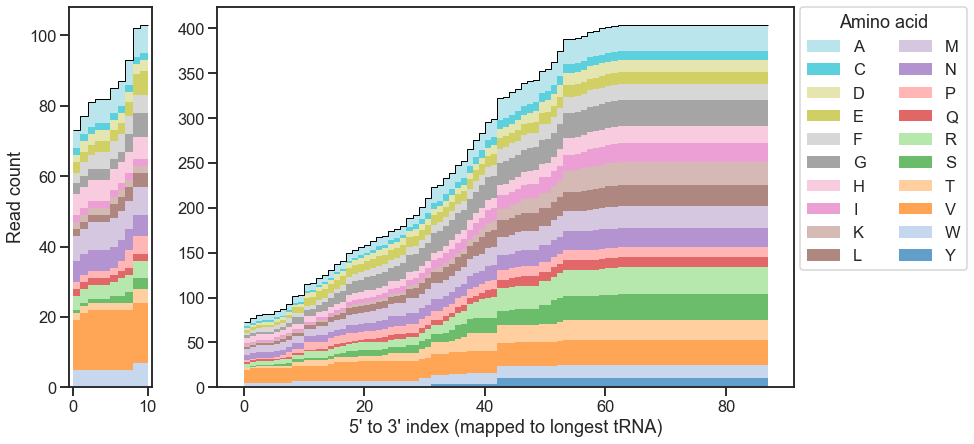

In [433]:


cmap = mpl.colormaps['tab20']




fig, axes = plt.subplots(1, 2, figsize=(13, 7), sharey=False, gridspec_kw={'width_ratios': [1, 7]})


for i in range(1, len(cov_count_sum)):
    axes[0].stairs(cov_count_sum[i, 0:10], baseline=cov_count_sum[i-1, 0:10], fill=True, alpha=0.7, color=cmap(i-1))
    # axes[1].stairs(cov_count_sum[i, 0:10], baseline=cov_count_sum[i-1, 0:10], fill=True, alpha=1, color=cmap(i-2))
axes[0].stairs(cov_count_sum[i, 0:10], baseline=None, fill=False, edgecolor='black', alpha=1, linewidth=1)



for i in range(1, len(cov_count_sum)):
    axes[1].stairs(cov_count_sum[i], baseline=cov_count_sum[i-1], fill=True, alpha=0.7, label=aa_ordered_list[i-1], color=cmap(i-1))
axes[1].stairs(cov_count_sum[i], baseline=None, fill=False, edgecolor='black', alpha=1, linewidth=1)

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1], labels[::-1], title='Amino acid', bbox_to_anchor=(1.01,1), borderaxespad=0, ncol=2);


axes[0].set_ylabel('Read count')
axes[1].set_xlabel("5' to 3' index (mapped to longest tRNA)");


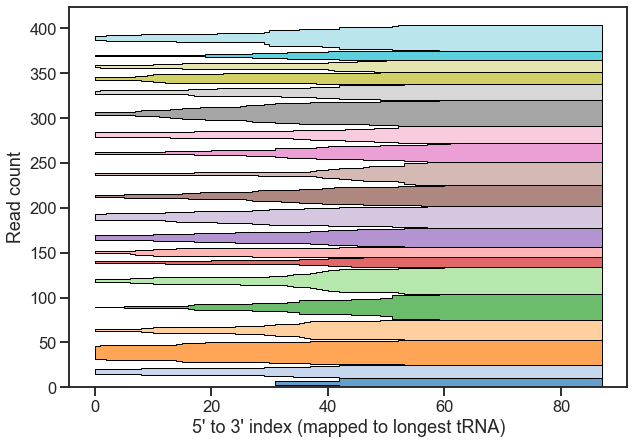

In [387]:
last_col = cov_count_sum[:, -1]
last_col_mid = np.zeros(last_col.shape[0]-1)
for i in range(1, last_col.shape[0]):
    delta = last_col[i] - last_col[i-1]
    last_col_mid[i-1] = last_col[i-1] + delta/2

cov_funnel_top = np.zeros(cov_count.shape)
cov_funnel_bot = np.zeros(cov_count.shape)
for i in range(0, cov_count.shape[1]):
    delta = cov_count[:, i]
    bottom = last_col_mid - delta/2
    top = last_col_mid + delta/2
    cov_funnel_top[:, i] = top
    cov_funnel_bot[:, i] = bottom






fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for i in range(0, len(cov_funnel_top)):  
    ax.stairs(cov_funnel_top[i, :], baseline=cov_funnel_bot[i, :], fill=True, edgecolor='black', alpha=0.7, color=cmap(i))
    
    funnel_mask = cov_funnel_top[i] > cov_funnel_bot[i]
    edges = np.where(funnel_mask)[0]
    edges = np.hstack((edges, edges[-1]+1))
    ax.stairs(cov_funnel_top[i, funnel_mask], edges, baseline=cov_funnel_bot[i, funnel_mask], edgecolor='black', alpha=1, linewidth=1)


ax.set_ylabel('Read count')
ax.set_xlabel("5' to 3' index (mapped to longest tRNA)");

In [84]:
seq_len = np.percentile([len(s) for s in agg_df['3p_non-temp']], 99.9, method='nearest')
#seq_list = ['-'*(seq_len - len(s)) + s for s in agg_df['5p_non-temp'].values if len(s) <= seq_len]
#counts_mat = lm.alignment_to_matrix(seq_list)

mask = [len(s) <= seq_len for s in agg_df['3p_non-temp'].values]
seq_list = [s+'-'*(seq_len - len(s)) for s in agg_df.loc[mask, '3p_non-temp'].values if len(s) <= seq_len]
counts_mat = lm.alignment_to_matrix(seq_list, agg_df.loc[mask, 'count'].values)


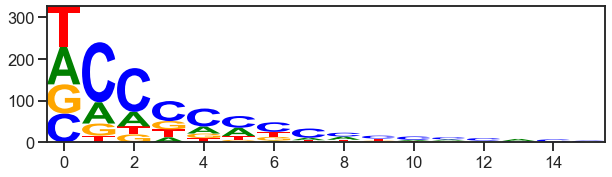

In [85]:
lm.Logo(counts_mat)

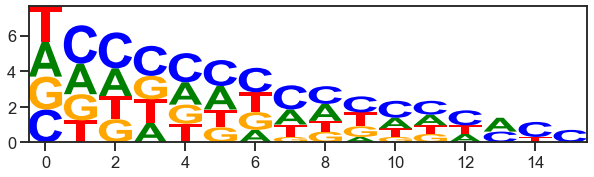

In [69]:
lm.Logo(np.log10(counts_mat+1))

In [ ]:
np.percentile

In [86]:
np.version.version

'1.19.2'

In [71]:
mat = lm.alignment_to_matrix(['AAA', 'CC-'], characters_to_ignore='-')
mat

,A,C
pos,,
0,1.0,1.0
1,1.0,1.0
2,1.0,0.0


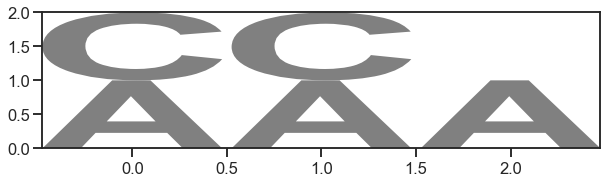

In [65]:
lm.Logo(mat)

In [66]:
lm.get_example_matrix('logomaker_logo_matrix',
                                       print_description=False)

,L,O,G,m,a,k,e,r
pos,,,,,,,,
0,0.8,0.0,0.0,-0.5,0.0,0.0,0.0,0.0
1,0.0,0.6,0.0,0.0,-0.5,0.0,0.0,0.0
2,0.0,0.0,0.6,0.0,0.0,-0.5,0.0,0.0
3,0.0,0.6,0.0,0.0,0.0,0.0,-0.5,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5


In [13]:
%%bash
pwd

/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen


In [15]:
%%bash
ls data

AdapterRemoval
BC_split
SWalign
UMI_trimmed
raw_fastq
raw_fastq_DSA-10k
stats_collection
stats_filtered_CC-CCA-aggregate.csv
stats_strict_filtered_CC-CCA-aggregate.csv


In [16]:
agg_df = pd.read_csv('/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/stats_filtered_CC-CCA-aggregate.csv')

In [17]:
# Extract a dataframe for charge data:
dfcol = agg_df.columns.values
col_mask = (dfcol != 'align_3p_nt') & (dfcol != 'count')
cols_sele = dfcol[col_mask]
df_charge = pd.DataFrame(columns=cols_sele)
df_charge['charge'] = []
df_charge['Ncharge'] = []


# Count A/C endings:
df_dict = dict()
for row in agg_df.iterrows():
    key = tuple(row[1].loc[cols_sele])
    if key in df_dict:
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
    else:
        df_dict[key] = dict()
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
# Add 0 count if count is missing,
# then calculate the charge percentage:
for key in df_dict.keys():
    if 'A' not in df_dict[key]:
        df_dict[key]['A'] = 0
    if 'C' not in df_dict[key]:
        df_dict[key]['C'] = 0

    df_dict[key]['charge'] = df_dict[key]['A'] / (df_dict[key]['A'] + df_dict[key]['C']) * 100
    df_dict[key]['Ncharge'] = (df_dict[key]['A'] + df_dict[key]['C'])

# Use a tmp file to write charge
# and total counts for the row (Ncharge),
# then load into dataframe:
try:
    os.remove('tmp_df.csv')
except:
    pass
with open('tmp_df.csv', 'a') as fh_csv:
    df_charge.to_csv(fh_csv, header=True, index=False)
    for i, key in enumerate(df_dict.keys()):
        row = list(key)
        row.append(df_dict[key]['charge'])
        row.append(df_dict[key]['Ncharge'])
        # df_charge.loc[i] = row # Too slow
        print(','.join(map(str, row)), file=fh_csv)
df_charge = pd.read_csv('tmp_df.csv')
os.remove('tmp_df.csv')

# Add RPM:
for nam in set(df_charge['sample_name'].values):
    rowm = df_charge['sample_name'] == nam
    df_charge.loc[rowm, 'RPM'] = df_charge.loc[rowm, 'Ncharge'].values / (df_charge.loc[rowm, 'Ncharge'].sum()/1e6)
df_charge['logRPM'] = np.log10(df_charge['RPM'].values)

# Melt:
df_charge_melt = pd.melt(df_charge, id_vars=['sample_name'], value_vars=['charge', 'Ncharge', 'RPM', 'amino_acid', 'tRNA_annotation'])


NameError: name 'df_reads' is not defined

In [19]:
def plot_sample_vs_sample(SN1_ls, SN2_ls, df_charge, df_charge_melt, var='charge', amino_acid='all', transcript='all', min_obs=50, xyrange='percentile'):
    '''
    var = [charge, RPM]
    charge = CCA/(CCA+CC)
    RPM = reads per million i.e. how many reads of a given transcript annotation observed per million reads
    '''

    var1 = '{}_1'.format(var)
    var2 = '{}_2'.format(var)
    
    fig, axes = plt.subplots(ncols=len(SN1_ls), figsize=(6.5*len(SN1_ls), 5))
    try:
        len(axes)
    except:
        axes = [axes]

    ax_i = 0
    for SN1, SN2 in zip(SN1_ls, SN2_ls):
        mask1 = np.array([False]*len(df_charge))
        for SN1_i in SN1.split('+'):
            mask1 = mask1 | (df_charge['sample_name'] == SN1_i)
        #mask1 = (df_charge['sample_name'] == SN1)

        mask2 = np.array([False]*len(df_charge))
        for SN2_i in SN2.split('+'):
            mask2 = mask2 | (df_charge['sample_name'] == SN2_i)
        #mask2 = (df_charge['sample_name'] == SN2)

        m12 = pd.merge(
            df_charge[mask1],
            df_charge[mask2],
            how="inner",
            on='tRNA_annotation',
            left_index=False,
            right_index=False,
            sort=True,
            suffixes=("_1", "_2"),
            copy=True,
            indicator=False,
            validate=None,
        )


        min_mask = (m12['Ncharge_1'] > min_obs) & (m12['Ncharge_2'] > min_obs)
        x_vals = m12[min_mask][var1].values
        y_vals = m12[min_mask][var2].values
        xy_vals = np.array([x_vals, y_vals])
        # xy_min = 0
        # xy_max = max(xy_vals)
        if xyrange == 'percentile':
            xy_min = np.percentile(xy_vals, 3)
            xy_max = np.percentile(xy_vals, 97)
        else:
            xy_min, xy_max = xyrange
            
        

        g1 = sns.regplot(ax=axes[ax_i], data=m12[min_mask], x=var1, y=var2)
        if var == 'charge':
            g1.set_xlabel('% charge (sample={})'.format(SN1))
            g1.set_ylabel('% charge (sample={})'.format(SN2))
            g1.set_title('Charge vs. charge (min obs = {})'.format(min_obs))
            axes[ax_i].set(ylim=[xy_min, xy_max])
            axes[ax_i].set(xlim=[xy_min, xy_max])
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        elif var == 'RPM':
            g1.set_xlabel('RPM (sample={})'.format(SN1))
            g1.set_ylabel('RPM (sample={})'.format(SN2))
            g1.set_title('RPM vs. RPM (min obs = {})'.format(min_obs))
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        elif var == 'logRPM':
            g1.set_xlabel('log(RPM) (sample={})'.format(SN1))
            g1.set_ylabel('log(RPM) (sample={})'.format(SN2))
            g1.set_title('RPM vs. RPM (min obs = {})'.format(min_obs))
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        ax_i += 1
        


In [22]:
df_charge.head(1)

,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,codon,anticodon,amino_acid,charge,Ncharge,RPM,logRPM
0,0m,3,l3Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,AAA,TTT,eColiLys,0.601323,1663,119.456917,2.077211


In [21]:
set(df_charge['sample_name'])

{'0m',
 '0p',
 '0p_90m',
 '100p',
 '10p',
 '16h',
 '16m',
 '1h',
 '25p',
 '2h',
 '32m',
 '40h',
 '40h_NoOx',
 '40p',
 '4h',
 '4m',
 '55p',
 '70p',
 '85p',
 '8h',
 '8m',
 'L1',
 'L10',
 'L11',
 'L12',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'R1',
 'R10',
 'R11',
 'R12',
 'R2',
 'R3',
 'R4',
 'R5',
 'R6',
 'R7',
 'R8',
 'R9'}

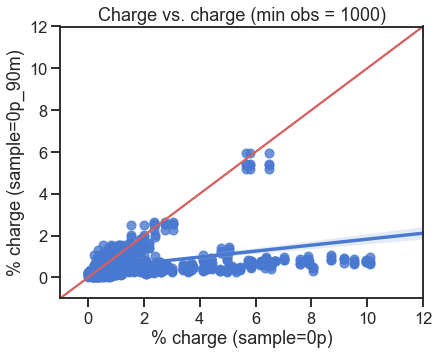

In [30]:
for i in [1000]:
    plot_sample_vs_sample(['0p'], ['0p_90m'], df_charge, df_charge_melt, min_obs=i, xyrange=(-1, 12))

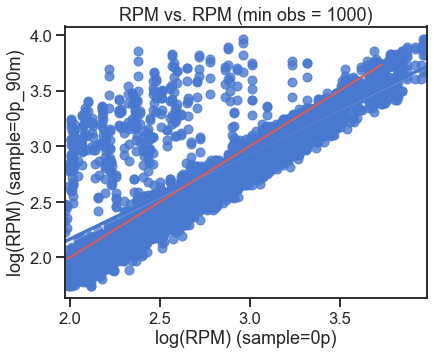

In [34]:
plot_sample_vs_sample(['0p'], ['0p_90m'], df_charge, df_charge_melt, min_obs=1000, var='logRPM')

In [40]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Add barcode sequences:
sample_df = index_to_sample_df(sample_df, index_df)

df_charge = df_charge.merge(sample_df.loc[:, ['sample_name', 'replicate', 'barcode', 'plot_group', 'hue_name', 'hue_value', 'hue_order']], on=['sample_name', 'replicate'])

In [48]:
df_charge['mito_codon'] = ['mito_tRNA' in anno for anno in df_charge['tRNA_annotation'].values]
df_charge['human_codon'] = ['Homo_sapiens' in anno for anno in df_charge['tRNA_annotation'].values]
df_charge['AA_codon'] = [AA + '-' + codon for codon, AA in zip(df_charge['codon'].values, df_charge['amino_acid'].values)]

# Create single codon filter, to filter out sequences that map to
# tRNA sequences with different codon/anticodon:
single_codon = list()
for anno_str, anticodon in zip(df_charge['tRNA_annotation'].values, df_charge['anticodon'].values):
    sc = True
    anno_list = anno_str.split('@')
    for anno in anno_list:
        if not anno.split('-')[2] == anticodon:
            sc = False
    single_codon.append(sc)
df_charge['single_codon'] = single_codon

In [49]:
set(df_charge['plot_group'].values)

{'Acylation-half-life', 'Charge-titration', 'NoArg', 'NoLeu'}

In [55]:
# No normalization

plot_groups = set(df_charge['plot_group'].values)
for plot_group in plot_groups:
    Ngrp = len(set(df_charge[(df_charge['plot_group'] == plot_group)]['hue_order'].values))

    fig = plt.figure(figsize=(28/3*Ngrp, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    #mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 100) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 500) & (df_charge['single_codon']) & (df_charge['unique_annotation'])
    if sum(mask) == 0:
        continue
    hue_order = [t[0] for t in sorted(dict(zip(df_charge[mask]['hue_value'].values, df_charge[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
    
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    old_legend = g1.legend_
    handles = old_legend.legendHandles
    labels = hue_order
    title = df_charge[mask]['hue_name'].values[0]
    g1.legend(handles, labels, title=title, bbox_to_anchor=(1.01,1), borderaxespad=0)
 
    # mito tRNAs
    # mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] ==  plot_group) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 500) & (df_charge['single_codon']) & (df_charge['unique_annotation'])
    if sum(mask) == 0:
        continue
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
    g2.legend_.remove()

    plt.tight_layout()
    fig.savefig('{}.pdf'.format(plot_group))
    fig.clear()
    g1.clear()
    g2.clear()


<Figure size 8064x648 with 0 Axes>

<Figure size 8064x648 with 0 Axes>

<Figure size 8064x648 with 0 Axes>

<Figure size 6048x648 with 0 Axes>